# Vinyl Store

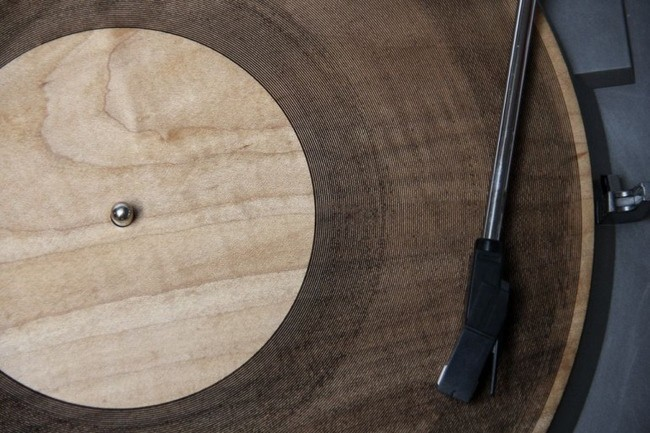

##        Introducción

Con motivo del "Record Store Day" (día mundial en el que se lanzan ediciones especiales de discos), la compañia discográfica "Eso a lo que tú llamas indie" está interesada en abrir su propia tienda de discos en la que distribuir su propio material.

Dado el auge que ha obtenido en la última década la compra/venta de discos de vinilo, su principal preocupación es definir una ubicación en Madrid adecuada, donde pueda tener una buena consolidación sin tener una excesiva competencia, ya que el mercado de conmpra/venta de discos de vinilo está en auge pero aún no está lo suficientemente expandido.

Este es el motivo del siguiente estudio que se detalla a continuación

## Índice

1 - [Instalación de librerías y módulos](#1---Instalación-de-librerías-y-módulos)

2 - [Recolección y preparación de los datos](#2---Recolección-y-preparación-de-los-datos)

3 - [Análisis de los datos](#3---Análisis-de-los-datos)

4 - [Conclusiones](#4---Conclusiones)


## 1 - Instalación de librerías y módulos

In [75]:
import numpy as np 

import pandas as pd 
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim 

import requests

import folium

from sklearn.cluster import KMeans

import seaborn as sb

## 2 - Recolección y preparación de los datos

EL objetivo es encontrar un barrio de Madrid donde se cumplan los siguientes requisitos:

- **Alta concentración de salas de conciertos y/o locales donde se toque música en directo:** La discográfica considera que su público objetivo, regenta este tipo de locales


- **Baja concentración de tiendas de música:** Esto limitará sustancialmente la competencia, por lo que ayudará a la consolidación de la tienda


- **Lo más cercano al centro posible:** El turismo en Madrid es elevado y principalmente los turistas suelen moverse por el centro de la ciudad. Muchos aficcionados a la música extranjero invierten tiempo y dinero en adquirir música en sus viajes al extranjero

Primero procederemos a obetener toda la información referente a los barrios de Madrid:

In [2]:
# Página de Wikipedia donde se detallan los barrios de Madrid

url='https://es.wikipedia.org/wiki/Anexo:Barrios_administrativos_de_Madrid' 

madrid_barrios = pd.read_html(url)
madrid_barrios = madrid_barrios[0].drop(['Superficie (km²)[2]\u200b','Imagen'],axis=1) 
madrid_barrios.head()

,Distrito,Número,Nombre
0,Centro,11,Palacio
1,Centro,12,Embajadores
2,Centro,13,Cortes
3,Centro,14,Justicia
4,Centro,15,Universidad


Con la ayuda del módulo Nominatim procedemos a obtener la latitud y longitud de cada barrio de Madrid:

In [3]:
#Crear las variables donde vamos a almacernar los valores de latitud y longitud

lat=np.zeros(madrid_barrios.shape[0])
long=np.zeros(madrid_barrios.shape[0])

#Crear una instancia de Nominatim 

geolocator = Nominatim(user_agent='foursquare_agent')
i=0

for barrio in madrid_barrios['Nombre']:
    loc='{}, Madrid, España'.format(barrio)
    
    #Aplicar el método geocode para obtener las coordenadas
    
    location = geolocator.geocode(loc)
    if location is None:
        print(i)
    else:
        lat[i] = location.latitude
        long[i] = location.longitude
    i+=1

116
128


Nos ha devuelto un error de localización en los barrios albergados en las filas 116 y 128, del DataFrame madrid_barrios

In [4]:
madrid_barrios.iloc[116]

Distrito      Vicálvaro
Número              193
Nombre      Valderrivas
Name: 116, dtype: object

In [5]:
madrid_barrios.iloc[128]

Distrito                       Barajas
Número                             213
Nombre      Casco Histórico de Barajas
Name: 128, dtype: object

Introducimos los datos de latitud y longitud de estos dos barrios manualmente. Los datos han sido obtenidos de las siguientes fuentes:

- https://geohack.toolforge.org/geohack.php?language=es&pagename=Valderrivas&params=40.401583333333_N_-3.5990944444444_E_type:city

- https://geohack.toolforge.org/geohack.php?language=es&pagename=Casco_Hist%C3%B3rico_de_Barajas&params=40.47361111_N_-3.57722222_E_type:city

In [6]:
lat[116] = 40.401583
long[116] = -3.599094

In [7]:
lat[128] = 40.473611
long[128] = -3.577222

Completamos el DataFrame madrid_barrios, con los datos obtenidos de latitud y longitud

In [8]:
madrid_barrios['Latitud']=lat
madrid_barrios['Longitud']=long
madrid_barrios.head()

,Distrito,Número,Nombre,Latitud,Longitud
0,Centro,11,Palacio,40.415129,-3.715618
1,Centro,12,Embajadores,40.409681,-3.701644
2,Centro,13,Cortes,40.414779,-3.697584
3,Centro,14,Justicia,40.423276,-3.696680
4,Centro,15,Universidad,40.425426,-3.706023


Una de las variables que se han defindido para una correcta evaluación del problema, es la distancia de cada barrio al centro. Para ello necesitaremos una función que nos calule la distancia al centro de la ciudad, en base a la latitud y la longitud

In [9]:
def distancia (lt,lg,ltc = 40.416729, lgc = -3.703339):
    import math
    R = 6371.004

    Mlng_A = lt
    Mlat_A = 90 - lg

    Mlng_B = ltc
    Mlat_B = 90 - lgc

    C = math.sin(Mlat_A*math.pi/180) * math.sin(Mlat_B*math.pi/180) * math.cos((Mlng_A - Mlng_B)*math.pi/180) +math.cos(Mlat_A*math.pi/180) * math.cos(Mlat_B*math.pi/180)
    Distance = R * math.acos(C)

    return Distance

Añadimos una nueva columna a cada barrio, donde figure la distancia al centro de la ciudad

In [10]:
dist = np.zeros(madrid_barrios.shape[0])
i=0
for lat,long in zip(madrid_barrios['Latitud'],madrid_barrios['Longitud']):
    dist[i] = distancia(lat,long)
    i+=1
madrid_barrios['Distancia'] = dist
madrid_barrios.head()

,Distrito,Número,Nombre,Latitud,Longitud,Distancia
0,Centro,11,Palacio,40.415129,-3.715618,1.376854
1,Centro,12,Embajadores,40.409681,-3.701644,0.804495
2,Centro,13,Cortes,40.414779,-3.697584,0.675495
3,Centro,14,Justicia,40.423276,-3.696680,1.037271
4,Centro,15,Universidad,40.425426,-3.706023,1.010150


Con la ayuda de la API de Foursquare obtenemos los lugares de cada barrio donde se celebren eventos de artes escénicas (teatros, salsas de conciertos, etc. Categoría API Foursquare 10035), así como tiendas de música (Categoría API Foursquare 17113).

In [11]:
#Funcion para obtener los lugares donde se celebran eventos de artes escénicasb, a partir de los valores de latitud y longitud

def get_places (names, latitudes, longitudes, categoria, distancia, radius=1000):
    
    from IPython.display import clear_output
    
    places_list=[]
    progress = len(names)
    cont = 0
    
    for name, lat, lng, dist in zip(names, latitudes, longitudes, distancia):
        clear_output()
        cont += 1
        print('Completado: {0:.2f}%'.format(cont*100/progress))
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v3/places/search?ll={lat}%2C{long}&radius={rad}&categories={cat}&limit=50'.format(
            lat = lat, 
            long = lng, 
            rad = radius,
            cat = categoria)
        headers = {"Accept": "application/json",
                   "Authorization": "fsq3w/faWPiUvcZbnNqok8a6rIWcM326rXx9djp28xJ/93g="}
            
        # solicitud GET
        response = requests.request("GET", url, headers=headers).json()
        results = response['results']
        
        # regresa solo información relevante de lugar de interés
        places_list.append([(
            name, 
            dist, 
            p['name'], 
            p['geocodes']['main']['latitude'], 
            p['geocodes']['main']['longitude'],  
            p['categories'][0]['name']) 
            for p in results])

    lugares_cercanos = pd.DataFrame([item for lugares_list in places_list for item in lugares_list])
    lugares_cercanos.columns = ['Barrio',
                               'Distancia Centro',
                               'Lugar',
                               'Latitud Lugar',
                               'Longitud Lugar',
                               'Categoría Lugar']
    
    return(lugares_cercanos) 
 

Obtenemos un DataFrame con los lugares donde se celbran eventos de artes escénicas (Categoria Foursquare 10035)

In [12]:
madrid_lugares = get_places(names=madrid_barrios['Nombre'],
                            latitudes=madrid_barrios['Latitud'],
                            longitudes=madrid_barrios['Longitud'],
                            distancia=madrid_barrios['Distancia'],
                            categoria=10035)
madrid_lugares

Completado: 100.00%


,Barrio,Distancia Centro,Lugar,Latitud Lugar,Longitud Lugar,Categoría Lugar
0,Palacio,1.376854,Corral de la Morería,40.412760,-3.714035,Concert Hall
1,Palacio,1.376854,ContraClub,40.412533,-3.713977,Concert Hall
2,Palacio,1.376854,Las Tablas Tablao Flamenco,40.421889,-3.713589,Music Venue
3,Palacio,1.376854,Teseo Teatro,40.408551,-3.715884,Theater
4,Palacio,1.376854,Las Carboneras,40.414744,-3.709295,Music Venue
...,...,...,...,...,...,...
1237,Timón,3.396441,El Grito,40.380319,-3.707109,Rock Club
1238,Timón,3.396441,Teatro Benavente,40.393019,-3.707500,Theater
1239,Timón,3.396441,Big Step,40.393857,-3.706994,Music Venue
1240,Timón,3.396441,Producciones el Zurdo,40.393967,-3.711080,Theater


Obtenemos un DataFrame con las tiendas de discos (Categoría Foursquare 17113)

In [13]:
madrid_tiendas = get_places(names=madrid_barrios['Nombre'],
                            latitudes=madrid_barrios['Latitud'],
                            longitudes=madrid_barrios['Longitud'],
                            distancia=madrid_barrios['Distancia'],
                            categoria=17113)
madrid_tiendas

Completado: 100.00%


,Barrio,Distancia Centro,Lugar,Latitud Lugar,Longitud Lugar,Categoría Lugar
0,Palacio,1.376854,Discos la Metralleta,40.418644,-3.706733,Record Store
1,Palacio,1.376854,Escridiscos,40.419094,-3.706467,Record Store
2,Palacio,1.376854,La Gramola,40.419166,-3.705977,Record Store
3,Palacio,1.376854,La quinta de Mahler,40.417069,-3.710689,Record Store
4,Palacio,1.376854,Sun Records,40.420474,-3.709101,Record Store
...,...,...,...,...,...,...
68,Argüelles,2.109148,Nakasha Discos,40.432598,-3.714253,Record Store
69,Argüelles,2.109148,Toni Martin Discos,40.425170,-3.714396,Record Store
70,Argüelles,2.109148,La Gramola,40.424995,-3.707120,Record Store
71,Pueblo Nuevo,6.885574,Cuna Records,40.434677,-3.636429,Record Store


Concatenamos ambos DataFrames en uno solo para poder trabajar sonbre él

In [14]:
madrid = pd.concat([madrid_lugares,madrid_tiendas])
madrid.index = range(madrid.shape[0])
madrid

,Barrio,Distancia Centro,Lugar,Latitud Lugar,Longitud Lugar,Categoría Lugar
0,Palacio,1.376854,Corral de la Morería,40.412760,-3.714035,Concert Hall
1,Palacio,1.376854,ContraClub,40.412533,-3.713977,Concert Hall
2,Palacio,1.376854,Las Tablas Tablao Flamenco,40.421889,-3.713589,Music Venue
3,Palacio,1.376854,Teseo Teatro,40.408551,-3.715884,Theater
4,Palacio,1.376854,Las Carboneras,40.414744,-3.709295,Music Venue
...,...,...,...,...,...,...
1310,Argüelles,2.109148,Nakasha Discos,40.432598,-3.714253,Record Store
1311,Argüelles,2.109148,Toni Martin Discos,40.425170,-3.714396,Record Store
1312,Argüelles,2.109148,La Gramola,40.424995,-3.707120,Record Store
1313,Pueblo Nuevo,6.885574,Cuna Records,40.434677,-3.636429,Record Store


Para poder aplicar un mejor análisis de los datos, sería interesante poder disponer de un DataFrame que nos defina las características más relevantes de cada barrio

In [15]:
#Creamos un DataFrame en el que nos codifique las distintas categorías

madrid_categoria = pd.get_dummies(madrid['Categoría Lugar'], prefix="", prefix_sep="")
madrid_categoria['Barrio'] = madrid['Barrio']
madrid_categoria


,Comedy Club,Concert Hall,Indie Theater,Jazz and Blues Venue,Music Venue,Performing Arts Venue,Record Store,Rock Club,Theater,Barrio
0,0,1,0,0,0,0,0,0,0,Palacio
1,0,1,0,0,0,0,0,0,0,Palacio
2,0,0,0,0,1,0,0,0,0,Palacio
3,0,0,0,0,0,0,0,0,1,Palacio
4,0,0,0,0,1,0,0,0,0,Palacio
...,...,...,...,...,...,...,...,...,...,...
1310,0,0,0,0,0,0,1,0,0,Argüelles
1311,0,0,0,0,0,0,1,0,0,Argüelles
1312,0,0,0,0,0,0,1,0,0,Argüelles
1313,0,0,0,0,0,0,1,0,0,Pueblo Nuevo


In [16]:
#Creamos un DataFrame en el que cada fila sea un barrio y contenga la cantidad de lugares de interés para nuestro problema
barrios = madrid_categoria.groupby('Barrio').sum().reset_index()
barrios

,Barrio,Comedy Club,Concert Hall,Indie Theater,Jazz and Blues Venue,Music Venue,Performing Arts Venue,Record Store,Rock Club,Theater
0,Abrantes,0,1,0,0,0,1,0,2,1
1,Acacias,2,9,3,0,15,1,1,0,20
2,Adelfas,0,0,0,1,4,0,0,0,3
3,Alameda de Osuna,0,1,0,0,0,0,0,0,0
4,Almagro,0,11,1,0,5,0,0,1,13
...,...,...,...,...,...,...,...,...,...,...
93,Vallehermoso,0,1,0,0,3,1,0,2,13
94,Ventas,0,3,0,0,2,1,0,1,12
95,Vinateros,0,1,0,0,0,0,0,0,0
96,Vista Alegre,1,6,0,0,3,0,0,0,2


Para una correcta visualización de los datos, es interesante tener también las coordenadas de cada barrio, además de añadir la distancia al centro, ya que es un valor importante. Eso podemos obtenerlo con la unión de los DataFrames madrid_barrios y barrios

In [17]:
barrios =barrios.merge(madrid_barrios[['Nombre','Latitud','Longitud','Distancia']],
                       how='left',
                       right_on='Nombre',
                       left_on='Barrio')
barrios.drop(columns='Nombre',inplace=True)
barrios

,Barrio,Comedy Club,Concert Hall,Indie Theater,Jazz and Blues Venue,Music Venue,Performing Arts Venue,Record Store,Rock Club,Theater,Latitud,Longitud,Distancia
0,Abrantes,0,1,0,0,0,1,0,2,1,40.381328,-3.727455,4.756185
1,Acacias,2,9,3,0,15,1,1,0,20,40.404075,-3.705957,1.433996
2,Adelfas,0,0,0,1,4,0,0,0,3,40.401903,-3.670958,3.958680
3,Alameda de Osuna,0,1,0,0,0,0,0,0,0,40.457581,-3.587975,13.605442
4,Almagro,0,11,1,0,5,0,0,1,13,40.433663,-3.694286,2.131744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Vallehermoso,0,1,0,0,3,1,0,2,13,40.443189,-3.710823,3.051762
94,Ventas,0,3,0,0,2,1,0,1,12,40.430831,-3.663280,4.721211
95,Vinateros,0,1,0,0,0,0,0,0,0,40.405197,-3.641547,6.989153
96,Vista Alegre,1,6,0,0,3,0,0,0,2,40.387792,-3.739654,5.158987


Como paso previo al análisis de los datos, vamos a observar en un mapa los 99 barrios de los que tenemos datos

In [113]:
#Creamos un mapa de la ciudad de Madrid

mapa = folium.Map([40.416729,-3.703339],zoom_start=11.5)

#Asignamos una marca a cada barrio del que tenemos registro

for b, lat, long in zip(barrios['Barrio'],barrios['Latitud'],barrios['Longitud']):
    label = folium.Popup(b,parse_html=False)
    folium.CircleMarker([lat,long],radius=4,popup=label,color='green',fill_color='green',fill_opacity=1).add_to(mapa)

mapa

## 3 - Análisis de los datos

Nos vamos ayudar de la metodología K-Means para clasdificar los 99 barrios que tenemos en clusters. Luego analizaremos los resultados para determinar la mejor ubicación

In [19]:
k_mean = KMeans(n_clusters=5,random_state=0).fit(barrios.drop(columns='Barrio'))

In [20]:
k_mean.labels_

array([0, 4, 3, 0, 1, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 3, 3, 0, 0, 3, 0, 3,
       1, 3, 0, 0, 3, 0, 2, 0, 3, 3, 0, 3, 2, 0, 3, 0, 1, 4, 3, 0, 3, 0,
       3, 1, 3, 2, 0, 3, 1, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 3, 4, 0, 4, 0,
       0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 0, 3, 0, 0, 3, 0, 0, 0, 2, 3, 4, 2,
       0, 0, 0, 0, 0, 1, 1, 0, 3, 0])

In [21]:
barrios['Cluster']=k_mean.labels_
barrios

,Barrio,Comedy Club,Concert Hall,Indie Theater,Jazz and Blues Venue,Music Venue,Performing Arts Venue,Record Store,Rock Club,Theater,Latitud,Longitud,Distancia,Cluster
0,Abrantes,0,1,0,0,0,1,0,2,1,40.381328,-3.727455,4.756185,0
1,Acacias,2,9,3,0,15,1,1,0,20,40.404075,-3.705957,1.433996,4
2,Adelfas,0,0,0,1,4,0,0,0,3,40.401903,-3.670958,3.958680,3
3,Alameda de Osuna,0,1,0,0,0,0,0,0,0,40.457581,-3.587975,13.605442,0
4,Almagro,0,11,1,0,5,0,0,1,13,40.433663,-3.694286,2.131744,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Vallehermoso,0,1,0,0,3,1,0,2,13,40.443189,-3.710823,3.051762,1
94,Ventas,0,3,0,0,2,1,0,1,12,40.430831,-3.663280,4.721211,1
95,Vinateros,0,1,0,0,0,0,0,0,0,40.405197,-3.641547,6.989153,0
96,Vista Alegre,1,6,0,0,3,0,0,0,2,40.387792,-3.739654,5.158987,3


Creamos una nueva columna que sea la suma de todos los lugares del barrio donde se realicen eventos músicales

In [31]:
barrios['Music Places'] = barrios['Concert Hall'] + barrios['Jazz and Blues Venue'] + barrios['Music Venue'] + barrios['Rock Club']

In [32]:
barrios

,Barrio,Comedy Club,Concert Hall,Indie Theater,Jazz and Blues Venue,Music Venue,Performing Arts Venue,Record Store,Rock Club,Theater,Latitud,Longitud,Distancia,Cluster,Music Places
0,Abrantes,0,1,0,0,0,1,0,2,1,40.381328,-3.727455,4.756185,0,3
1,Acacias,2,9,3,0,15,1,1,0,20,40.404075,-3.705957,1.433996,4,24
2,Adelfas,0,0,0,1,4,0,0,0,3,40.401903,-3.670958,3.958680,3,5
3,Alameda de Osuna,0,1,0,0,0,0,0,0,0,40.457581,-3.587975,13.605442,0,1
4,Almagro,0,11,1,0,5,0,0,1,13,40.433663,-3.694286,2.131744,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Vallehermoso,0,1,0,0,3,1,0,2,13,40.443189,-3.710823,3.051762,1,6
94,Ventas,0,3,0,0,2,1,0,1,12,40.430831,-3.663280,4.721211,1,6
95,Vinateros,0,1,0,0,0,0,0,0,0,40.405197,-3.641547,6.989153,0,1
96,Vista Alegre,1,6,0,0,3,0,0,0,2,40.387792,-3.739654,5.158987,3,9


Visualicemos los datos en el mapa asignando un valor a cada cluster

In [114]:
mapa_cluster = folium.Map([40.416729,-3.703339],zoom_start=11.5)

colores = ['red','green','yellow','blue','black']

for b, lat, long, c in zip(barrios['Barrio'],barrios['Latitud'],barrios['Longitud'],barrios['Cluster']):
    label = folium.Popup(b,parse_html=False)
    folium.CircleMarker([lat,long],
                        radius=4,
                        popup=label,
                        color=colores[c],
                        fill_color=colores[c],
                        fill_opacity=1).add_to(mapa_cluster)

mapa_cluster

Se puede observar que la distribución de los cústers tienen una clara dependencia de la distancia de los barrios al centro de la ciudad. 

Visualicemos los datos de cada cluster:

In [66]:
def ver_cluster(df, cluster=0):
    
    df_cluster = df[df['Cluster']==cluster]
    print('La media de tiendas de música por barrio es de {0:.2f} tiendas'.format(df_cluster['Record Store'].mean()))
    print('La media de sitios donde se realizan eventos musicales por barrio es de {0:.2f} lugares'.format(df_cluster['Music Places'].mean()))
    return df_cluster[['Barrio','Record Store','Music Places','Distancia']]
    

### Cluster 0 (Color rojo)

In [67]:
ver_cluster(barrios,cluster=0)

La media de tiendas de música por barrio es de 0.04 tiendas
La media de sitios donde se realizan eventos musicales por barrio es de 1.52 lugares


,Barrio,Record Store,Music Places,Distancia
0,Abrantes,0,3,4.756185
3,Alameda de Osuna,0,1,13.605442
5,Almenara,0,2,6.030171
6,Almendrales,0,1,3.618045
7,Aluche,0,3,6.562207
8,Amposta,0,0,8.832185
10,Aravaca,0,0,9.938483
11,Arcos,0,0,9.456913
13,Atalaya,0,1,6.785179
17,Canillas,0,3,8.343002


### Cluster 1 (Color verde)

In [68]:
ver_cluster(barrios,cluster=1)

La media de tiendas de música por barrio es de 0.25 tiendas
La media de sitios donde se realizan eventos musicales por barrio es de 11.12 lugares


,Barrio,Record Store,Music Places,Distancia
4,Almagro,0,17,2.131744
22,Chopera,0,6,2.438248
38,Fuente del Berro,0,6,4.446719
45,Imperial,1,17,1.896203
50,Lista,0,8,3.486656
75,Recoletos,1,23,2.150034
93,Vallehermoso,0,6,3.051762
94,Ventas,0,6,4.721211


### Cluster 2 (Color amarillo)

In [69]:
ver_cluster(barrios,cluster=2)

La media de tiendas de música por barrio es de 9.00 tiendas
La media de sitios donde se realizan eventos musicales por barrio es de 32.20 lugares


,Barrio,Record Store,Music Places,Distancia
28,Cortes,8,32,0.675495
34,Embajadores,3,32,0.804495
47,Justicia,9,32,1.037271
84,Sol,11,33,0.173994
87,Universidad,14,32,1.010150


### Cluster 3 (Color azul)

In [70]:
ver_cluster(barrios,cluster=3)

La media de tiendas de música por barrio es de 0.04 tiendas
La media de sitios donde se realizan eventos musicales por barrio es de 5.00 lugares


,Barrio,Record Store,Music Places,Distancia
2,Adelfas,0,5,3.958680
15,Bellas Vistas,0,3,3.969086
16,Berruguete,0,4,4.832791
19,Castellana,0,6,2.867111
21,Castillejos,0,10,4.897792
23,Ciudad Jardín,0,7,4.830310
26,Comillas,0,3,2.711397
30,Cuatro Caminos,0,5,3.335400
31,Delicias,1,4,2.650248
33,El Viso,0,7,3.748753


### Cluster 4 (Color negro)

In [81]:
ver_cluster(barrios,cluster=4)

La media de tiendas de música por barrio es de 2.88 tiendas
La media de sitios donde se realizan eventos musicales por barrio es de 22.00 lugares


,Barrio,Record Store,Music Places,Distancia
1,Acacias,1,24,1.433996
9,Arapiles,4,24,2.076284
12,Argüelles,4,25,2.109148
14,Atocha,1,17,1.965713
39,Gaztambide,2,14,2.383264
62,Palacio,8,22,1.376854
64,Palos de Moguer,1,23,1.706318
86,Trafalgar,2,27,1.830561


In [77]:
data_analisis = []
for c in range(5):
    df_a = barrios[barrios['Cluster']==c]
    rs = df_a['Record Store'].mean()
    mp = df_a['Music Places'].mean()
    d = df_a['Distancia'].mean()
    data_analisis.append((rs,mp,d))

analisis = pd.DataFrame(data=data_analisis,columns=['Record Store', 'Music Places', 'Distancia'])
analisis

,Record Store,Music Places,Distancia
0,0.040000,1.520,7.425796
1,0.250000,11.125,3.040322
2,9.000000,32.200,0.740281
3,0.037037,5.000,3.721949
4,2.875000,22.000,1.860267


<AxesSubplot:>

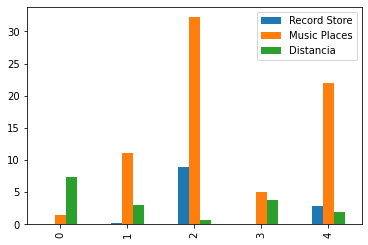

In [80]:
analisis.plot(kind = 'bar')

Realizamos un análisis preliminar por cluster:

- **Cluster 0:** Es una zona que podemos descartar de antemano. Tiene una baja concentración de tiendas de discos, pero son barrios muy alejados del centro y con pocos luegares donde se realicen eventos de artes escénicas


- **Cluster 1:** Es una zona con muchos lugares donde se realizan espectáculos de artes escénicas y hay pocas tiendas de música. La desventaja que tiene que la distancia al centro no es mucha pero no es la más cercana


- **Cluster 2:** Es una zona con muchas lugares donde se realizan espectáculos de artes escénicas y muy céntrico (Esta zona se compone únicamente de los cinco barrios más céntricos de la ciudad). Como contra tiene que también es que es la zona con mayor concentración de tiendas de música


- **Cluster 3:** Es una zona que también podríamos descartar en una primera aproximación. Es el segundo cluster más alejado del centro, y también es el segundo con menos lugares donde se celebren artes escénicas


- **Cluster 4:** Es una zona interesante, ya que se cumplen los requisitos buscados: Cercanía al centro, gran concentración de lugars con artes escénicas, y pocas tiendas de música


Con este análisis preliminar podríamso descartar los barrios de los clústers 0 y 3 por su gran distancia al centro de la ciudad. Y los barrios del clúster 2, que son los barrios más céntricos pero también los que tienen una mayor concentración de tiendas de música

Con esto únicamente nos queda optar por algún barrio del clúster 1 o 4. Empecemos analizando el clúster 4 que es el más cercano al centro:

In [95]:
min_rs = barrios[barrios['Cluster']==4]['Record Store'].min()
barrios[(barrios['Record Store']==min_rs) & (barrios['Cluster']==4)]

,Barrio,Comedy Club,Concert Hall,Indie Theater,Jazz and Blues Venue,Music Venue,Performing Arts Venue,Record Store,Rock Club,Theater,Latitud,Longitud,Distancia,Cluster,Music Places
1,Acacias,2,9,3,0,15,1,1,0,20,40.404075,-3.705957,1.433996,4,24
14,Atocha,0,5,0,1,11,0,1,0,21,40.406975,-3.688582,1.965713,4,17
64,Palos de Moguer,1,9,1,1,13,0,1,0,25,40.403638,-3.695287,1.706318,4,23


Podemos ver que el barrio más propicio para emplazar nuestra nueva tienda es Acacias, ya que tiene una única tienda de música, y 24 lugares donde se realizan eventos relacionados con música, y por último sólo está a 1.43 km del centro de la ciudad

Veamos con detalle la informacón del clúster 1

In [101]:
ver_cluster(barrios,cluster=1)

La media de tiendas de música por barrio es de 0.25 tiendas
La media de sitios donde se realizan eventos musicales por barrio es de 11.12 lugares


,Barrio,Record Store,Music Places,Distancia
4,Almagro,0,17,2.131744
22,Chopera,0,6,2.438248
38,Fuente del Berro,0,6,4.446719
45,Imperial,1,17,1.896203
50,Lista,0,8,3.486656
75,Recoletos,1,23,2.150034
93,Vallehermoso,0,6,3.051762
94,Ventas,0,6,4.721211


Vemos que en esta zona ninguno de los barrios mejora la predisposción del barrio de Acacias que vimos en el punto anterior. Hay 3 barrios que podrían ser viables, pero no tienen tan buena predisposición como Acacias:

- Almagro

- Imperial

- Recoletos

## 4 - Conclusiones

Como resultado de nuestro analisis a la hora de encontrar la mejor ubicación para una nueva tienda de música, obtenemos que el barrio de **Acacias** es el que mejor se adapta a las especificaciones que se detallan en el primer punto de este informe.

Aún así se adjuntan al resultado final los 4 barrios con mejor predisposición a ubicar la tienda:

1 - Acacias

2 - Imperial

3 - Almagro

4 - Recoletos

Esta es su ubicación en el mapa

In [112]:
mapa_final = folium.Map([40.416729,-3.703339],zoom_start=13.5)

colores = ['red','green','yellow','blue','black']
df_top_4 = barrios[barrios.Barrio.isin(['Acacias','Imperial','Almagro','Recoletos'])]

for b, lat, long, c in zip(df_top_4['Barrio'],df_top_4['Latitud'],df_top_4['Longitud'],df_top_4['Cluster']):
    label = folium.Popup(b,parse_html=False)
    folium.CircleMarker([lat,long],
                        radius=7,
                        popup=label,
                        color=colores[c],
                        fill_color=colores[c],
                        fill_opacity=1).add_to(mapa_final)

mapa_final